In [1]:
import os

In [2]:
%pwd

'c:\\Users\\bohra\\Mnist_fashion_model\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd


'c:\\Users\\bohra\\Mnist_fashion_model'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_optimizer: int
    params_learning_rate: float
    param: dict
 

In [6]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = (self.config.data_ingestion.train_data)
        create_directories([Path(training.root_dir)])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            base_model_path=Path(prepare_base_model.base_model_path),
            training_data=Path(training_data),
            params_epochs=params.num_epochs,
            params_batch_size=params.batch_size,
            params_optimizer=params.optimizer,
            params_learning_rate = params.learning_rate,
            param = dict(params),
        )

        return training_config

In [8]:
import os
import urllib.request as request
import time
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torchvision import transforms
from cnnClassifier import logger
from cnnClassifier.utils.training_utils import log_model_n_params,train_val_split,validate_model
from cnnClassifier.utils.training_utils import evaluation_metrics_n_Hyperparameters,plot_loss_accuracy
from cnnClassifier.utils.common import transform_train

In [9]:
# Define the transform_train function
def transform_train():
    return transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
class Training:

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_loss_list = []
        self.train_accuracy_list = []
        self.val_loss_list = [] 
        self.val_accuracy_list = []
        self.best_val_accuracy = 0

    def train_val_split(self):
        train_set =torchvision.datasets.FashionMNIST(self.config.training_data, download=True,transform=transform_train())


        train_ratio = 0.8  # Adjust as needed
        train_size = int(train_ratio * len(train_set))
        val_size = len(train_set) - train_size

        train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

        self.train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=self.config.params_batch_size)
        self.valid_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=self.config.params_batch_size)
    
    def get_base_model(self):
        self.model = torch.load(f'{self.config.base_model_path}', map_location=self.device)

    def save_model(self):
        torch.save(self.model, self.config.trained_model_path)
    
    def train_model(self):

        error = nn.CrossEntropyLoss()
        model1 = self.model
        # Initialize the optimizer based on optimizer_name
        if self.config.params_optimizer == 0:
            optimizer = torch.optim.Adam(model1.parameters(), lr=self.config.params_learning_rate)
        elif self.config.params_optimizer == 1:
            optimizer = torch.optim.SGD(model1.parameters(), lr=self.config.params_learning_rate)

        # Lists for knowing classwise accuracy
        predictions_list = []
        labels_list = []

        running_loss = 0
        total = 0
        scheduler = StepLR(optimizer, step_size=(self.config.params_epochs)/2, gamma=0.1)
       
        # Directory to save model checkpoints
        checkpoint_dir = 'checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)

        file_path = 'checkpoints\checkpoint_model.pth'

        if os.path.exists(file_path):
            self.model = torch.load('checkpoints\checkpoint_model.pth', map_location=self.device)
            logger.info('checkpoint_model')

        for epoch in range(self.config.params_epochs):

            for images, labels in self.train_loader:

                # Transfering images and labels to GPU if available
                images, labels = images.to(self.device), labels.to(self.device)

                if images.shape[1] == 1:
                 images = images.repeat(1, 3, 1, 1)  # Repeat the grayscale channel 3 times

                train = images.view(100, 3, 28, 28)
                labels = labels


                # Forward pass
                outputs = self.model(train)
                loss = error(outputs, labels)
                running_loss += loss.item() * images.size(0)
                predictions = torch.max(outputs, 1)[1].to(self.device)
                predictions_list.append(predictions)
                labels_list.append(labels)

                # Initializing a gradient as 0 so there is no mixing of gradient among the batches
                optimizer.zero_grad()
                #Propagating the error backward
                loss.backward()
                # Optimizing the parameters
                optimizer.step()
                # Total
                total += len(labels)

            # loss calculation
            train_loss = running_loss / total

            scheduler.step()  # Update learning rate

        # validation
            validate_model(self.model,self.valid_loader,checkpoint_dir,epoch,self.best_val_accuracy,
                                 self.device,self.val_loss_list,self.val_accuracy_list)
        #logging and evaluating metrics_n_Hyperparameters
            evaluation_metrics_n_Hyperparameters(self,labels_list,predictions_list,train_loss,epoch)

        #plotting loss and accuracy
        plot_loss_accuracy(self.train_loss_list, self.train_accuracy_list, 
                           self.val_loss_list, self.val_accuracy_list,self.config.params_epochs)

        #logging the model
        log_model_n_params(self.model,labels_list,predictions_list,self.config.param)
       
        


   





[2024-07-23 06:00:28,362: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-07-23 06:00:28,369: INFO: common: yaml file: params.yaml loaded successfully]
[2024-07-23 06:00:28,370: INFO: common: created directory at: artifacts]
[2024-07-23 06:00:28,370: INFO: common: created directory at: artifacts\training]
[2024-07-23 06:00:28,593: INFO: 579134621: checkpoint_model]
[2024-07-23 06:08:50,011: INFO: training_utils: validation_loss: 0.41502078870932263,validation_accuracy: 0.8479166666666667%]
Model checkpoint saved at checkpoints\checkpoint_model.pth
[2024-07-23 06:08:50,420: INFO: training_utils: epoch: 0, Loss: 0.4137761090261241, Accuracy: 0.8480625%]


Registered model 'model1' already exists. Creating a new version of this model...
Created version '2' of model 'model1'.


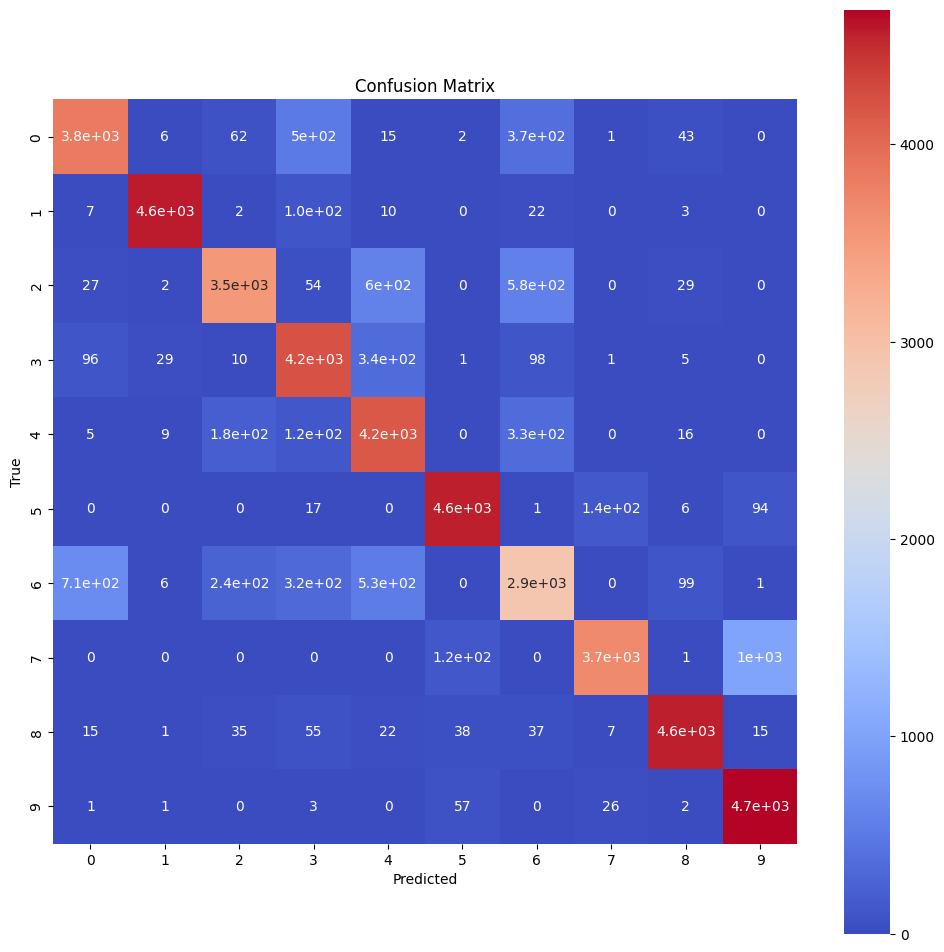

dict_keys(['confusion_matrix'])
[[3830, 6, 62, 500, 15, 2, 369, 1, 43, 0], [7, 4584, 2, 105, 10, 0, 22, 0, 3, 0], [27, 2, 3521, 54, 602, 0, 575, 0, 29, 0], [96, 29, 10, 4221, 341, 1, 98, 1, 5, 0], [5, 9, 185, 119, 4161, 0, 332, 0, 16, 0], [0, 0, 0, 17, 0, 4558, 1, 140, 6, 94], [713, 6, 244, 316, 528, 0, 2893, 0, 99, 1], [0, 0, 0, 0, 0, 122, 0, 3686, 1, 1007], [15, 1, 35, 55, 22, 38, 37, 7, 4569, 15], [1, 1, 0, 3, 0, 57, 0, 26, 2, 4684]]


<Figure size 640x480 with 0 Axes>

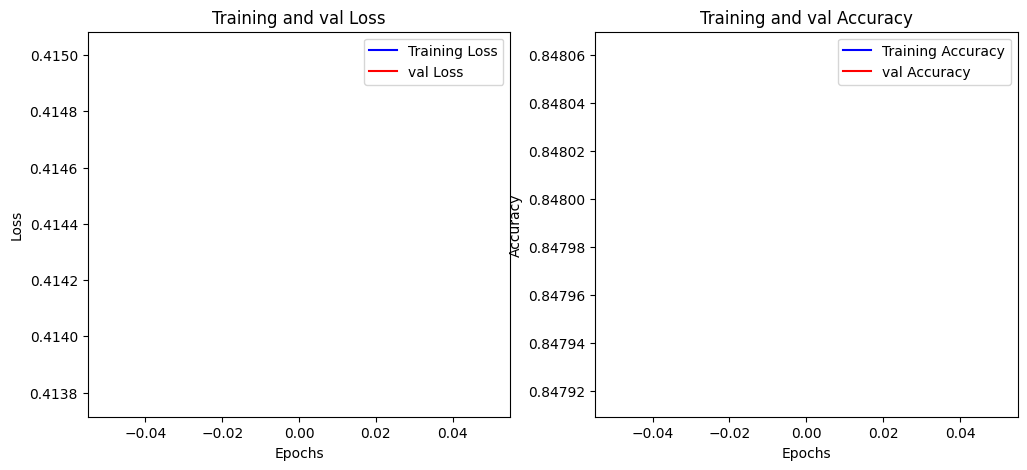

RuntimeError: File artifacts\training\model.h5 cannot be opened.

In [10]:
try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_val_split()
    training.train_model()
    training.save_model()
    
except Exception as e:
    raise e
